# Create and save masks of subbasins in the domain

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj
import cartopy.crs as ccrs
import geopandas as gp
import regionmask

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def abline(slope, intercept, axes):
    """Plot a line from slope and intercept"""
    axes_xlim = axes.get_xlim()
    axes_ylim = axes.get_ylim()
    x_vals = np.append(np.append(np.array(axes_xlim[0]-500), np.array(axes.get_xlim())), np.array(axes_xlim[1]+500))
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, linestyle='-', color="lightgray", linewidth=1)
    axes.set(xlim = axes_xlim, ylim = axes_ylim)

### Get domain lat-lon from a sample file

In [4]:
# just get a temporary to get the coordinates
wrf_hydro_temp = '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_4km/wrf_hydro_nwm_public-5.2.0_domain4_4km_LSMonly_defSoil_defPar/trunk/NDHMS/Run/'
ds_temp = xr.open_dataset(wrf_hydro_temp + 'OUTPUT/DAILY_FILES/LH_concatTime.nc')
X, Y = np.meshgrid(ds_temp.x.values, ds_temp.y.values)
source = Proj(ds_temp.proj4)
lon, lat = source(X.flatten(), Y.flatten(), inverse=True)
lon_2d = lon.reshape(X.shape)
lat_2d = lat.reshape(Y.shape)

# using a temporal mean dataset to check the mask
da_lh_mean = ds_temp['LH'].sel(time = '2016').mean('time')

In [10]:
data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'
#basin_names = ['goulburn', 'ovens', 'broken', 'murray_riverina', 'murrumbidgee', 'lachlan']
basin_names = ['kiewa', 'upper_murray', 'murrumbidgee']

latlon_rename = {'lat_idx':'y', 'lon_idx':'x'}

mask_list = []
for basin in basin_names:
    sh_basin = gp.read_file(data_dir + basin + '.shp')
    da_mask = regionmask.mask_geopandas(sh_basin, lon_2d, lat_2d)
    da_mask = xr.where(da_mask==0, 1, np.nan)
    da_mask = da_mask.rename(latlon_rename).assign_coords(da_lh_mean.coords)
    mask_list.append(da_mask)
    
    out_file = data_dir + basin + '_mask.nc'
    da_mask.to_netcdf(out_file)

In [28]:
! rm /g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/murrumbidgee_north_mask.nc
! rm /g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/murrumbidgee_south_mask.nc

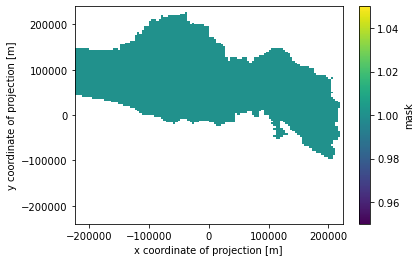

In [13]:
ds = xr.open_dataset(data_dir + 'murrumbidgee_mask.nc')
ds['mask'].plot()

### Save masks for the eastern & western halfs of Lachlan separately

In [62]:
da_lach_east_mask = mask_list[5].copy(deep=True)
da_lach_west_mask = mask_list[5].copy(deep=True)

da_lach_east_mask[:, 0:47] = np.nan
da_lach_west_mask[:, 47::] = np.nan

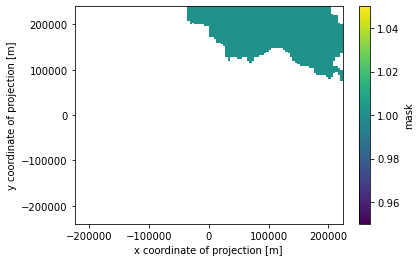

In [63]:
da_lach_east_mask.plot()

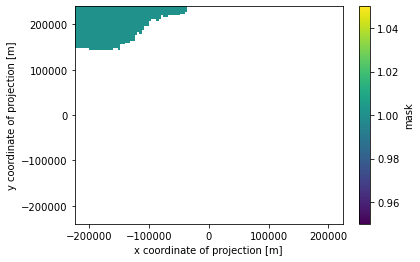

In [64]:
da_lach_west_mask.plot()

In [65]:
out_file = data_dir + 'lachlan_east_mask.nc'
da_lach_east_mask.to_netcdf(out_file)

out_file = data_dir + 'lachlan_west_mask.nc'
da_lach_west_mask.to_netcdf(out_file)

### Also the northern half of the Murrumbidgee

In [23]:
import xarray as xr
data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'
basin = 'murrumbidgee'
ds_mask = xr.open_dataset(data_dir + basin + '_mask.nc')

da_mask_north = ds_mask['mask'].copy(deep = True)
da_mask_north[0:78,:] = np.nan

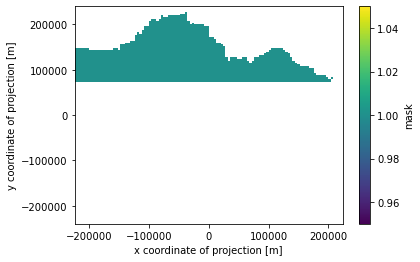

In [24]:
da_mask_north.plot()

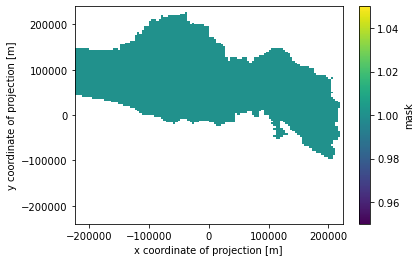

In [16]:
ds_mask['mask'].plot()

In [26]:
da_mask_south = ds_mask['mask'].copy(deep = True)
da_mask_south[78::,:] = np.nan

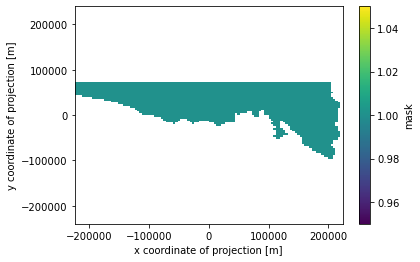

In [27]:
da_mask_south.plot()

In [29]:
da_mask_north.to_netcdf(data_dir + basin + '_north_mask.nc')
da_mask_south.to_netcdf(data_dir + basin + '_south_mask.nc')

In [22]:
# create a combined upper murray & kiewa mask

data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'

ds1 = xr.open_dataset(data_dir + 'kiewa_mask.nc')
ds2 = xr.open_dataset(data_dir + 'upper_murray_mask.nc')

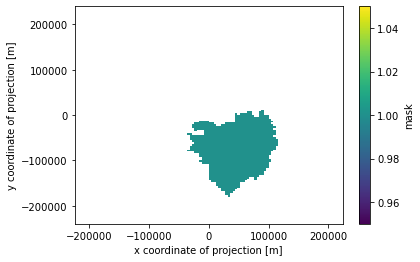

In [29]:
da_combined = xr.concat([ds1['mask'], ds2['mask']], dim='basin').sum('basin')
da_combined = da_combined.where(da_combined>0)
da_combined.plot()

In [31]:
da_combined.to_netcdf(data_dir + 'upper_basins_mask.nc')

### Save masks for 1km domain

In [3]:
! ls /g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_1km/

wrf_hydro_nwm_public-5.2.0_domain4_1km_100mRT_12g_defSoil_defPar
wrf_hydro_nwm_public-5.2.0_domain4_1km_12g_defSoil_defPar
wrf_hydro_nwm_public-5.2.0_domain4_1km_LSMonly_defSoil_defPar


In [6]:
# just get a temporary to get the coordinates
wrf_hydro_temp = '/g/data/w28/ad9701/WRF-Hydro/SEA/runs_wCalibPars_1km/wrf_hydro_nwm_public-5.2.0_domain4_1km_LSMonly_defSoil_defPar/trunk/NDHMS/Run/'
ds_temp = xr.open_dataset(wrf_hydro_temp + 'OUTPUT/DAILY_FILES/LH_concatTime.nc')
X, Y = np.meshgrid(ds_temp.x.values, ds_temp.y.values)
source = Proj(ds_temp.proj4)
lon, lat = source(X.flatten(), Y.flatten(), inverse=True)
lon_2d = lon.reshape(X.shape)
lat_2d = lat.reshape(Y.shape)

# using a temporal mean dataset to check the mask
da_lh_mean = ds_temp['LH'].sel(time = '2016').mean('time')

data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'
basin_names = ['goulburn', 'ovens', 'broken', 'murray_riverina', 'murrumbidgee', 'lachlan', 'kiewa', 'upper_murray', 'murrumbidgee']

latlon_rename = {'lat_idx':'y', 'lon_idx':'x'}

mask_list = []
for basin in basin_names:
    sh_basin = gp.read_file(data_dir + basin + '.shp')
    da_mask = regionmask.mask_geopandas(sh_basin, lon_2d, lat_2d)
    da_mask = xr.where(da_mask==0, 1, np.nan)
    da_mask = da_mask.rename(latlon_rename).assign_coords(da_lh_mean.coords)
    mask_list.append(da_mask)
    
    out_file = data_dir + basin + '_mask_1km.nc'
    da_mask.to_netcdf(out_file)

In [20]:
da_mask_concat = xr.concat(mask_list[0:-1], dim = 'basin').assign_coords({'basin':basin_names[0:-1]})
da_mask_concat

<xarray.DataArray 'mask' (basin: 8, y: 480, x: 448)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat      (y, x) float64 -37.83 -37.83 -37.83 -37.83 ... -33.52 -33.52 -33.52
    lon      (y, x) float64 144.6 144.6 144.6 144.6 ... 149.5 149.5 149.5 149.5
  * x        (x) float64 -2.235e+05 -2.225e+05 ... 2.225e+05 2.235e+05
  * y        (y) float64 -2.395e+05 -2.385e+05 ... 2.385e+05 2.395e+05
  * basin    (basin) <U15 'goulburn' 'ovens' 'broken' ... 'kiewa' 'upper_murray'

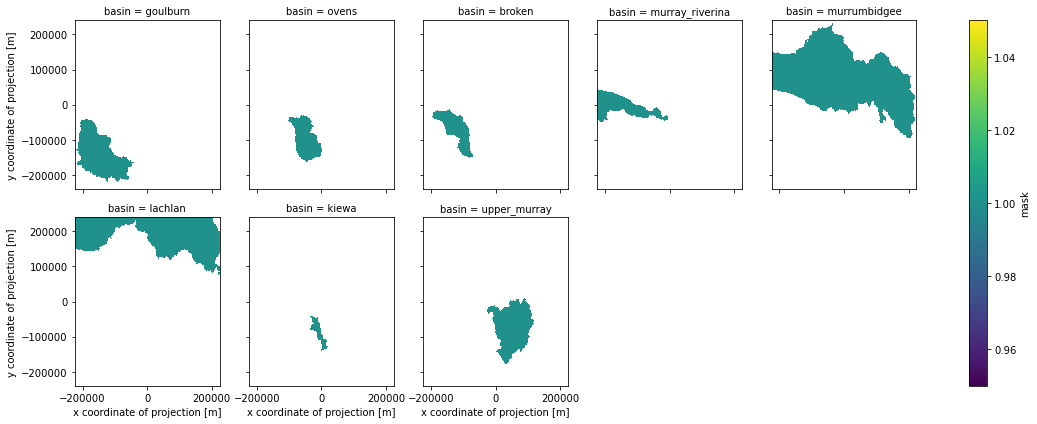

In [21]:
da_mask_concat.plot(col='basin', col_wrap=5)

In [ ]:
! ls /g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/

### 10-km resol. mask

In [6]:
# just get a temporary to get the coordinates
wrf_hydro_temp = '/scratch/w97/ad9701/WRF-Hydro/SEA/noGW_runs/runs_wNewCalibPars_10km/wrf_hydro_nwm_public-5.2.0_domain4_10km_monPnTCorr_LSMonly_defSoil_defPar/trunk/NDHMS/Run/'
ds_temp = xr.open_dataset(wrf_hydro_temp + 'OUTPUT/DAILY_FILES/LH_concatTime.nc')
X, Y = np.meshgrid(ds_temp.x.values, ds_temp.y.values)
source = Proj(ds_temp.proj4)
lon, lat = source(X.flatten(), Y.flatten(), inverse=True)
lon_2d = lon.reshape(X.shape)
lat_2d = lat.reshape(Y.shape)

# using a temporal mean dataset to check the mask
da_lh_mean = ds_temp['LH'].sel(time = '2016').mean('time')

data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'
basin_names = ['goulburn', 'ovens', 'broken', 'murray_riverina', 'murrumbidgee', 'lachlan', 'kiewa', 'upper_murray', 'murrumbidgee']

latlon_rename = {'lat_idx':'y', 'lon_idx':'x'}

mask_list = []
for basin in basin_names:
    sh_basin = gp.read_file(data_dir + basin + '.shp')
    da_mask = regionmask.mask_geopandas(sh_basin, lon_2d, lat_2d)
    da_mask = xr.where(da_mask==0, 1, np.nan)
    da_mask = da_mask.rename(latlon_rename).assign_coords(da_lh_mean.coords)
    mask_list.append(da_mask)
    
    out_file = data_dir + basin + '_mask_10km.nc'
    da_mask.to_netcdf(out_file)

In [7]:
da_mask_concat = xr.concat(mask_list[0:-1], dim = 'basin').assign_coords({'basin':basin_names[0:-1]})
da_mask_concat

<xarray.DataArray 'mask' (basin: 8, y: 48, x: 45)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 1.,  1.,  1., ...,  1.,  1., nan],
        [ 1.,  1.,  1., ...,  1., nan, nan],
        [ 1.,  1.,  1., ...,  1., nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lat      (y, x) float64 -37.79 -37.79 -37.79 -37.79 ... -33.57 -33.56 -33.56
    lon      (y, x) float64 144.6 144.7 144.8 145.0 ... 149.2 149.3 149.4 149.5
  * x        (x) float64 -2.2e+05 -2.1e+05 -2e+05 ... 2e+05 2.1e+05 2.2e+05
  * y        (y) float64 -2.35e+05 -2.25e+05 -2.15e+05 ... 2.25e+05 2.35e+05
  * basin    (basin) <U15 'goulburn' 'ovens' 'broken' ... 'kiewa' 'upper_murray'

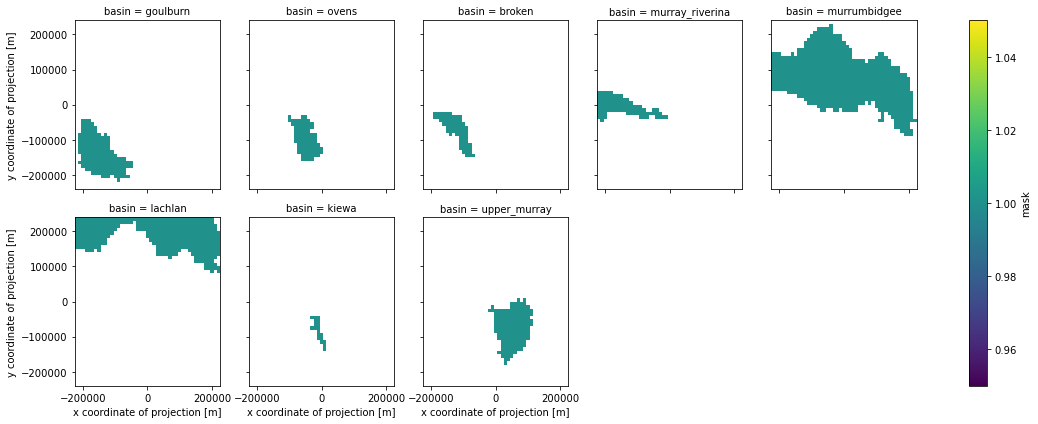

In [8]:
da_mask_concat.plot(col='basin', col_wrap=5)

In [9]:
# create a combined upper murray & kiewa mask

data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'

ds1 = xr.open_dataset(data_dir + 'kiewa_mask_1km.nc')
ds2 = xr.open_dataset(data_dir + 'upper_murray_mask_1km.nc')

da_combined = xr.concat([ds1['mask'], ds2['mask']], dim='basin').sum('basin')
da_combined = da_combined.where(da_combined>0)

da_combined.to_netcdf(data_dir + 'upper_basins_mask_1km.nc')

In [10]:
# create a combined upper murray & kiewa mask

data_dir = '/g/data/w97/ad9701/WRF-Hydro/SEA/shapefiles/individual_basins/'

ds1 = xr.open_dataset(data_dir + 'kiewa_mask_10km.nc')
ds2 = xr.open_dataset(data_dir + 'upper_murray_mask_10km.nc')

da_combined = xr.concat([ds1['mask'], ds2['mask']], dim='basin').sum('basin')
da_combined = da_combined.where(da_combined>0)

da_combined.to_netcdf(data_dir + 'upper_basins_mask_10km.nc')